# Chapter 8 Lab 1

## Goal
We are going to learn how to compute and interpret the following scalar metrics:

Accuracy
True Positive rate (TPR), or sensitivity
True negative rate (TNR), or specificity
Precision
Recall
F-measure
We will again consider the task of predicting players’ SkillLevel, which takes integer value between 0 and 3, with 0 being novice level and 3 expert.

For illustrative purposes, consider the Decision Tree model from Chapter 7, lab 7 (note that you can use any other model you have trained so far for this purpose).

## Preparation

Load the required packages below.

In [11]:
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score, classification_report, precision_recall_fscore_support, make_scorer, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Pre-processing and Model Building

We've done these steps enough to condense them together in order to speed the process of getting to metric evaluation.

In [3]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
dota_df1.drop(['PlayerID'], axis=1, inplace=True)

dota_df1 = dota_df1.rename(columns=lambda x: x.strip())

dota_df1['TotalTime'] = pd.to_numeric(dota_df1['TotalTime'], errors='coerce')

dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))

dota_df1.drop([517], inplace=True)

dota_df1.describe()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,8.670000e+02
mean,92.343714,50.369089,1.650519,0.711649,1014.840856,608.660900,0.131799,545.094579,951.763552,7636.831603,677.627451,1259.800461,70.786621,29.740484,2.283400e+05
std,205.574415,115.795471,3.239320,1.808982,119.954984,1502.754591,0.065829,1204.140278,2230.809200,19801.024410,2029.775852,2969.501221,175.869846,74.661056,4.751062e+05
min,1.000000,0.000000,0.000000,0.000000,626.837000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.349000e+03
25%,3.000000,1.000000,0.000000,0.000000,961.886000,11.000000,0.090000,17.500000,18.000000,160.500000,12.000000,16.000000,1.000000,0.000000,6.270000e+03
50%,15.000000,7.000000,0.000000,0.000000,996.646000,74.000000,0.130000,93.000000,125.000000,983.000000,76.000000,146.000000,7.000000,3.000000,3.516000e+04
75%,90.000000,47.500000,2.000000,1.000000,1046.975000,514.500000,0.170000,554.000000,865.000000,6732.000000,541.500000,1130.500000,62.000000,26.000000,2.234100e+05
max,3156.000000,1764.000000,40.000000,18.000000,2010.240000,23742.000000,0.420000,16988.000000,34390.000000,372360.000000,43910.000000,42900.000000,2601.000000,1141.000000,4.294920e+06


Next, we'll split the data first into predictors and target and then into training and test

In [4]:
y = dota_df1['SkillLevel']
X = dota_df1.drop(['SkillLevel'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

Laslty, since we don't need to standardize for the DecisionTreeClassifier, we'll run our model.

In [5]:
#Setup and configure settings for Repeated k-Fold CV (k-folds=10, repeats=10)
rcv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=101)

#define model
dtc = DecisionTreeClassifier()
scoring = {'Accuracy':'accuracy', 'Kappa':make_scorer(cohen_kappa_score)}
alphas = list(np.arange(0.1, 1.0, 0.04))
params = {'ccp_alpha':alphas}

#create model, perform Repeated CV and evaluate model
scores = GridSearchCV(dtc, params, scoring=scoring, cv=rcv, refit='Accuracy', n_jobs=-1)
scores.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=101),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.14, 0.18000000000000002,
                                       0.22000000000000003, 0.26,
                                       0.30000000000000004, 0.3400000000000001,
                                       0.38, 0.42000000000000004,
                                       0.4600000000000001, 0.5000000000000001,
                                       0.54, 0.5800000000000001,
                                       0.6200000000000001, 0.66,
                                       0.7000000000000001, 0.7400000000000001,
                                       0.7800000000000001, 0.8200000000000002,
                                       0.8600000000000001, 0.9000000000000001,
                                       0.9400000000000002,
                                       0.9800000000000001]},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'Kappa': make_scorer(cohen_kappa_score)})

In [6]:
scores.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.1)

Now, we use this 'best_params' to predict classes so we can evaluate the results using common metrics.

In [7]:
final_model = scores.best_estimator_
dtc_pred = final_model.predict(X_test)

## Step 2: Get performance measures

Python has no shortage of metrics reports which you can tap. However, it is helpful to initially run a report and then manually calculate the more common metrics in order to learn them better.

However, we will create a confusion table AFTER producing a brief report or two. Then we will use the outcomes of the confusion table in order to calculate certain metrics and compare them to what our code generated in the reports.

In [8]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, dtc_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.83      0.91       110
     class 1       0.78      1.00      0.88        98
     class 2       0.00      0.00      0.00         6
     class 3       0.00      0.00      0.00         3

    accuracy                           0.87       217
   macro avg       0.44      0.46      0.45       217
weighted avg       0.86      0.87      0.85       217



In [9]:
prfs = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test).astype(float)==l, np.array(dtc_pred.astype(float))==l, pos_label=True,average=None)
    prfs.append([recall[1],recall[0]])

pd.DataFrame(prfs, columns = ['sensitivity','specificity']).transpose()

,0,1,2,3
sensitivity,0.827273,1.000000,0.0,0.0
specificity,1.000000,0.764706,1.0,1.0


We're going to print out a confusion matrix - EXCEPT!! - this time we rotate it to align with the R output

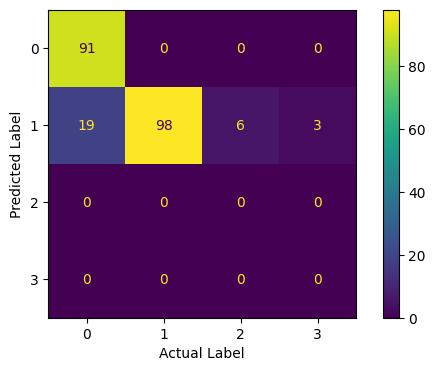

In [21]:
fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(dtc_pred, y_test)).plot(values_format=".0f", ax=ax)

ax.set_xlabel("Actual Label")
ax.set_ylabel("Predicted Label")
plt.show()

# Accuracy

Accuracy is computed as follows:

$$\text{Accuracy} = \frac{\sum_{i=0}^{3}{\text{TP}_{i}}}{\text{Total number of data points}}$$

Anything on the 'diagonal' of the matrix is a TP. So add those up and find what percentage of the total they represent.

$$\frac{(91+98)}{215} = 0.871$$

The agrees with the Accuracy measure in the classification report above.

# Sensitivity and Specificity

Both of these are class specific.

Sensitivity (which is the same as Recall) is the number of True predictions the classifier made out of all possible True predictions it could have made. In other words, it is the fraction of correctly assigned True points, computed as follows:

$$\text{Sensitivity of Class}_i = \frac{\text{TP}_i}{\text{TP}_i + \text{FN}_i}$$

For example, for Class 0:

$$\frac{91}{(91+19)} = 0.83$$

This is confirmed by both the sensitivity calculation in the small table above and the recall output for Class 0 in the larger report.

Specificity is is the number of False predictions the classifier made out of all possible False predictions it could have made. In other words, it is the fraction of correctly assigned False points, computed as follows:

$$\text{Specificity of Class}_i = \frac{\text{TN}_i}{\text{TN}_i + \text{FP}_i}$$

For Class 1:

$$\frac{91}{(91+19+6+3)} = 0.77$$

This is the same result for Class 1 in the smaller table.

# Precision, Recall and F-Measure

All of these are class specific as well.

Precision is the classifier's ability to avoid labeling an incorrect positive (that is, something that should be negative is labeled negative). It is calculated:

$$\text{Precision of Class}_i = \frac{\text{TP}_i}{\text{TP}_i + \text{FP}_i}$$

For Class 1:

$$\frac{98}{(98+19+6+3)} = 0.78$$

See the large report above to cross check this answer!

Recall (which is the same as Sensitivity) is the number of True predictions the classifier made out of all possible True predictions it could have made. In other words, it is the fraction of correctly assigned True points, computed as follows:

$$\text{Recall of Class}_i = \frac{\text{TP}_i}{\text{TP}_i + \text{FN}_i}$$

For example, for Class 0:

$$\frac{91}{(91+19)} = 0.83$$

This is confirmed by both the sensitivity calculation in the small table above and the recall output for Class 0 in the larger report.

Lastly, the F1 score is the weighted harmonic mean of Precision and Recall. It is calculated:

$$\text{F1 score of Class}_i = \frac{2 * \text{precision}_i * \text{recall}_i}{\text{precision}_i + \text{recall}_i}$$

For Class 0:

$$\frac{2*1.0*0.83}{(1.0+0.83)} = 0.91$$

You can check this answer in the full report above.

## Conclusion

This lab has demonstrated how to calculate scalar performance metrics on classification models such as DecisionTreeClassifier.  Which 'perspective' you take, i.e. whether or not to focus on a model's ability to predict positive cases, negative cases, or avoid certain cases, depends on your use case. A physician trying to diagnose cancer is much more worried about missing a positive case than incorrectly flagging a negative one, for example.